In [95]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from matplotlib import cm

In [96]:
df = pd.read_excel("../data/premiums_young.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [97]:
df.shape

(20096, 13)

### Data Cleaning: Converting titles into consistent names with lower case and underscore between 2 words

In [98]:
df.columns = df.columns.str.replace(" ", "_").str.lower()
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


### Handling NA Values

In [99]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [100]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Checking for duplicate values. If new file contains duplicates, the code can adjust for that

In [101]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [102]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


### Checking for and treating negative number of dependents

In [103]:
df[df.number_of_dependants<0].shape

(22, 13)

In [104]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1])

In [105]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

### Checking for outliers in other numeric columns

In [106]:
numeric_columns = df.select_dtypes(['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

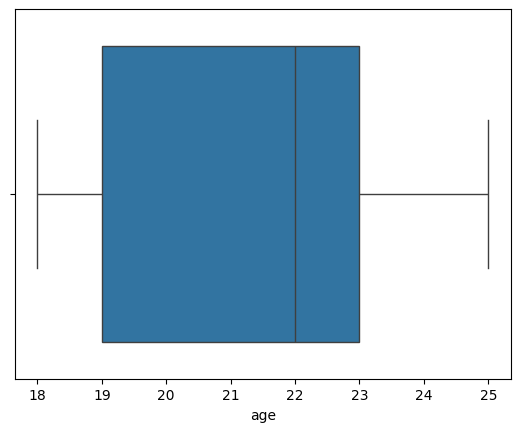

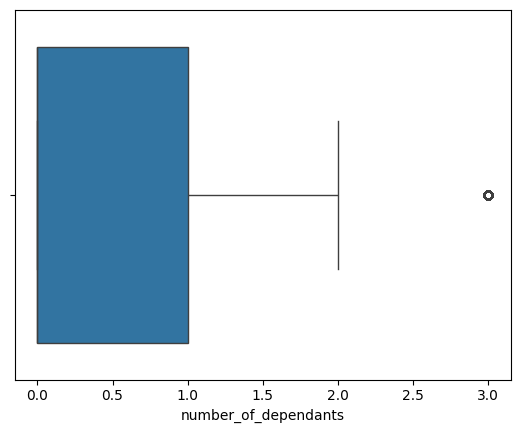

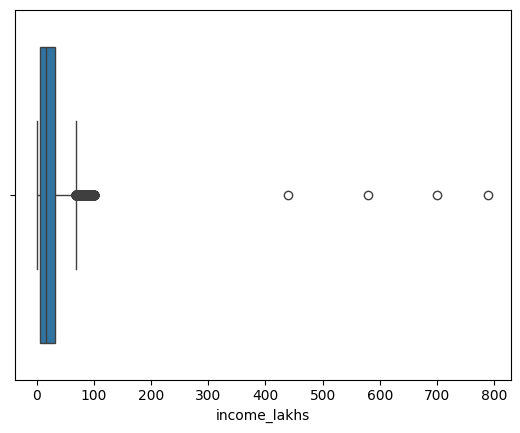

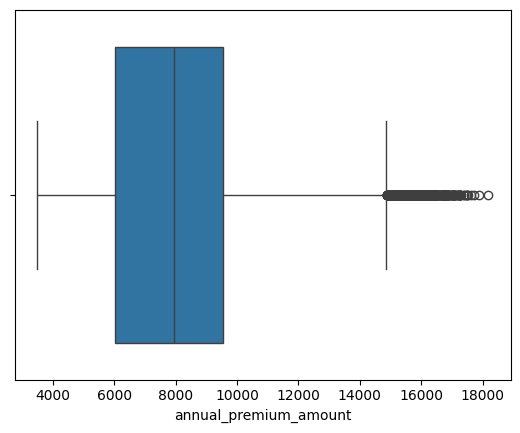

In [107]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

In [108]:
df[df.age>100]['age'].unique()

array([], dtype=int64)

In [109]:
#Dropping all rows with age > 100
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

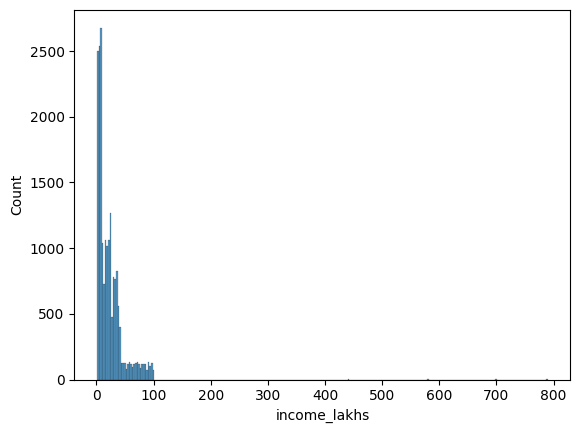

In [110]:
sns.histplot(df1.income_lakhs)

In [111]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound, upper_bound

In [112]:
get_iqr_bounds(df.income_lakhs)

(-31.5, 68.5)

In [113]:
#Upper bound is 67 Lakhs per annum, which is very reasonable in India. Hence, using a better upper limit using top 99% income
quantile_thresold = df1.income_lakhs.quantile(0.999)
quantile_thresold

np.float64(100.0)

In [114]:
df1[df1.income_lakhs>quantile_thresold].shape

(4, 13)

#### Only 10 people in our dataset have income greater than 100 lakhs per annum, so we can safely drop these as outliers

In [115]:
df2 = df1[df1.income_lakhs<=quantile_thresold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


### EDA 

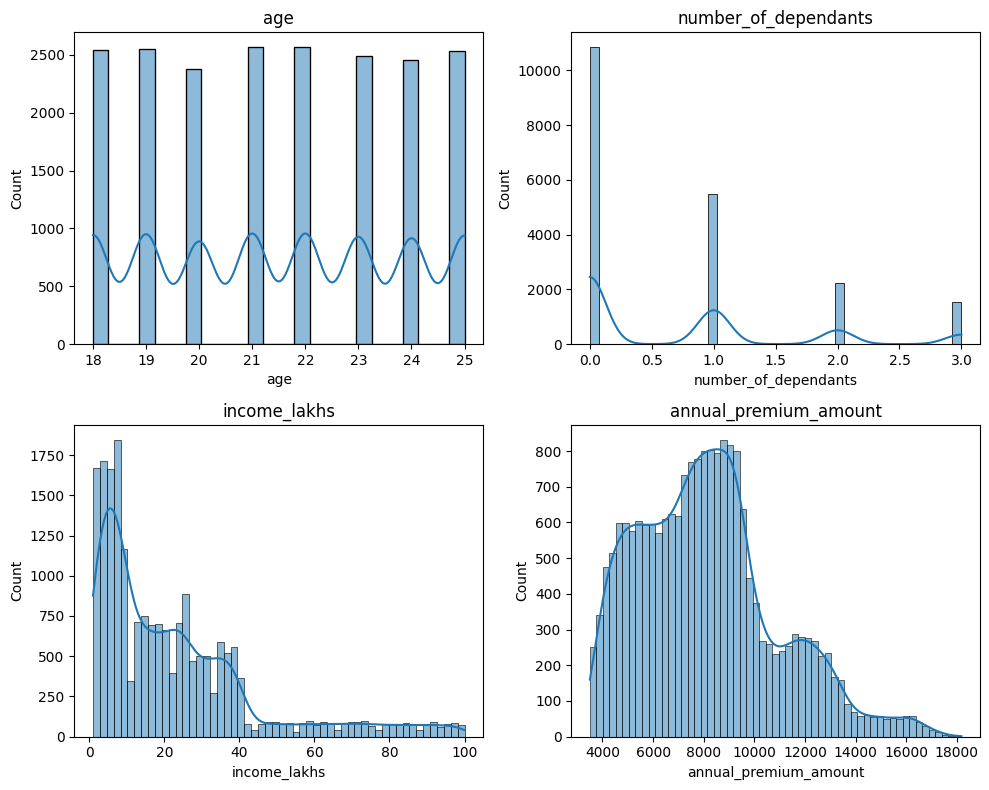

In [116]:
# Distributions for dataset after removing outliers
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
axs = axs.flatten()

for ax, col in zip(axs, numeric_columns):
    sns.histplot(df2[col], kde=True, ax=ax)
    ax.set_title(col)
    
plt.tight_layout()
plt.show()

### Bi-Variate Analysis between independent numeric variables and dependent numeric variable

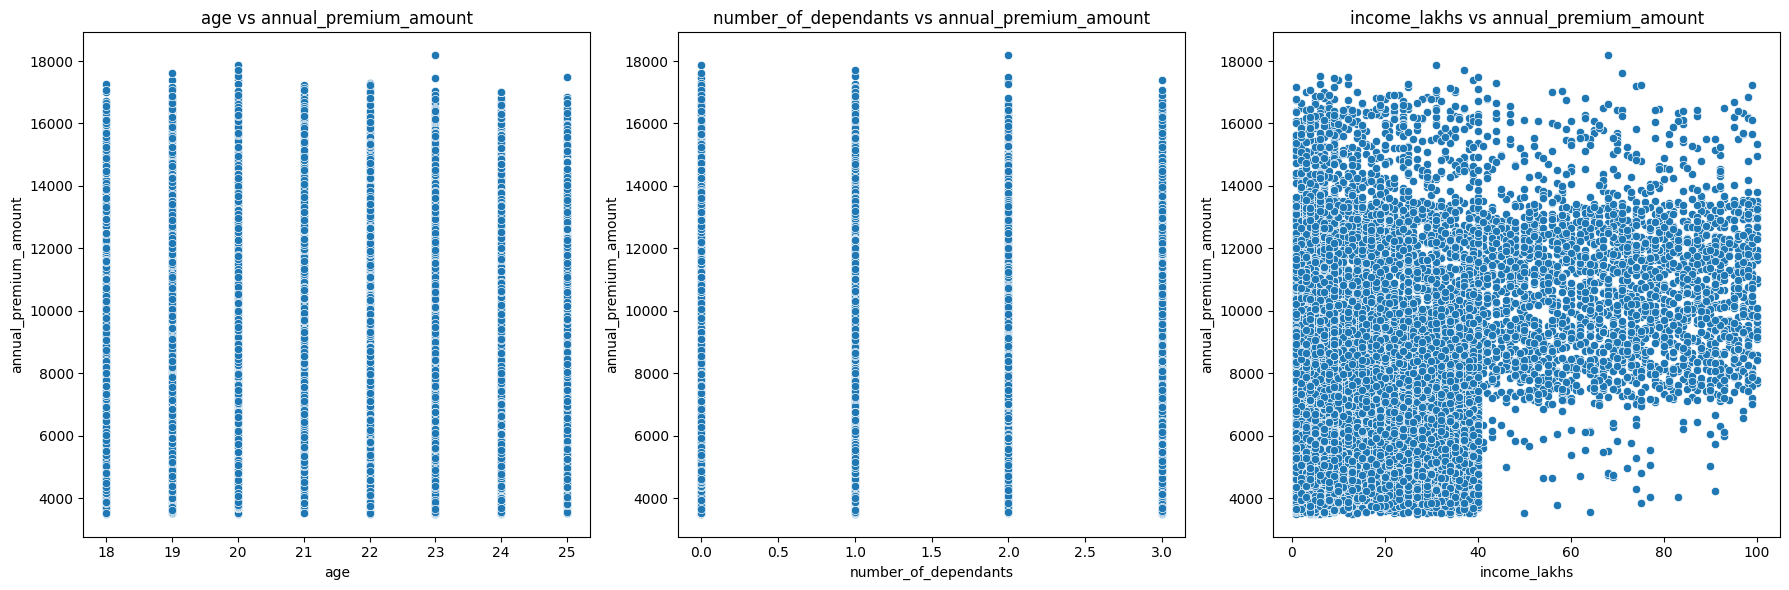

In [117]:
numeric_features = ['age', 'number_of_dependants', 'income_lakhs']

fig, axes = plt.subplots(1, len(numeric_features), figsize = (18,6))

for ax, col in zip(axes, numeric_features):
    sns.scatterplot(x=df2[col], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f"{col} vs annual_premium_amount")
    ax.set_xlabel(col)
    ax.set_ylabel("annual_premium_amount")

plt.tight_layout()
plt.show()


### Moving on to the categorical columns

In [118]:
df2.dtypes

age                       int64
gender                   object
region                   object
marital_status           object
number_of_dependants      int64
bmi_category             object
smoking_status           object
employment_status        object
income_level             object
income_lakhs              int64
medical_history          object
insurance_plan           object
annual_premium_amount     int64
dtype: object

In [119]:
categorical_cols = df2.select_dtypes('object').columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [120]:
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


### Replacing duplicate "No-smoking" values with one.

In [121]:
df2['smoking_status'] = df2['smoking_status'].replace({
    "Smoking=0": "No Smoking",
     "Does Not Smoke": "No Smoking",
     "Not Smoking": "No Smoking" 
})

df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [122]:
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

In [123]:
pct_count.values

array([0.55038335, 0.44961665])

### Percentage distribution of policy holders per categorical variable

C:\Users\kusha\AppData\Local\Temp\ipykernel_22256\2094765434.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


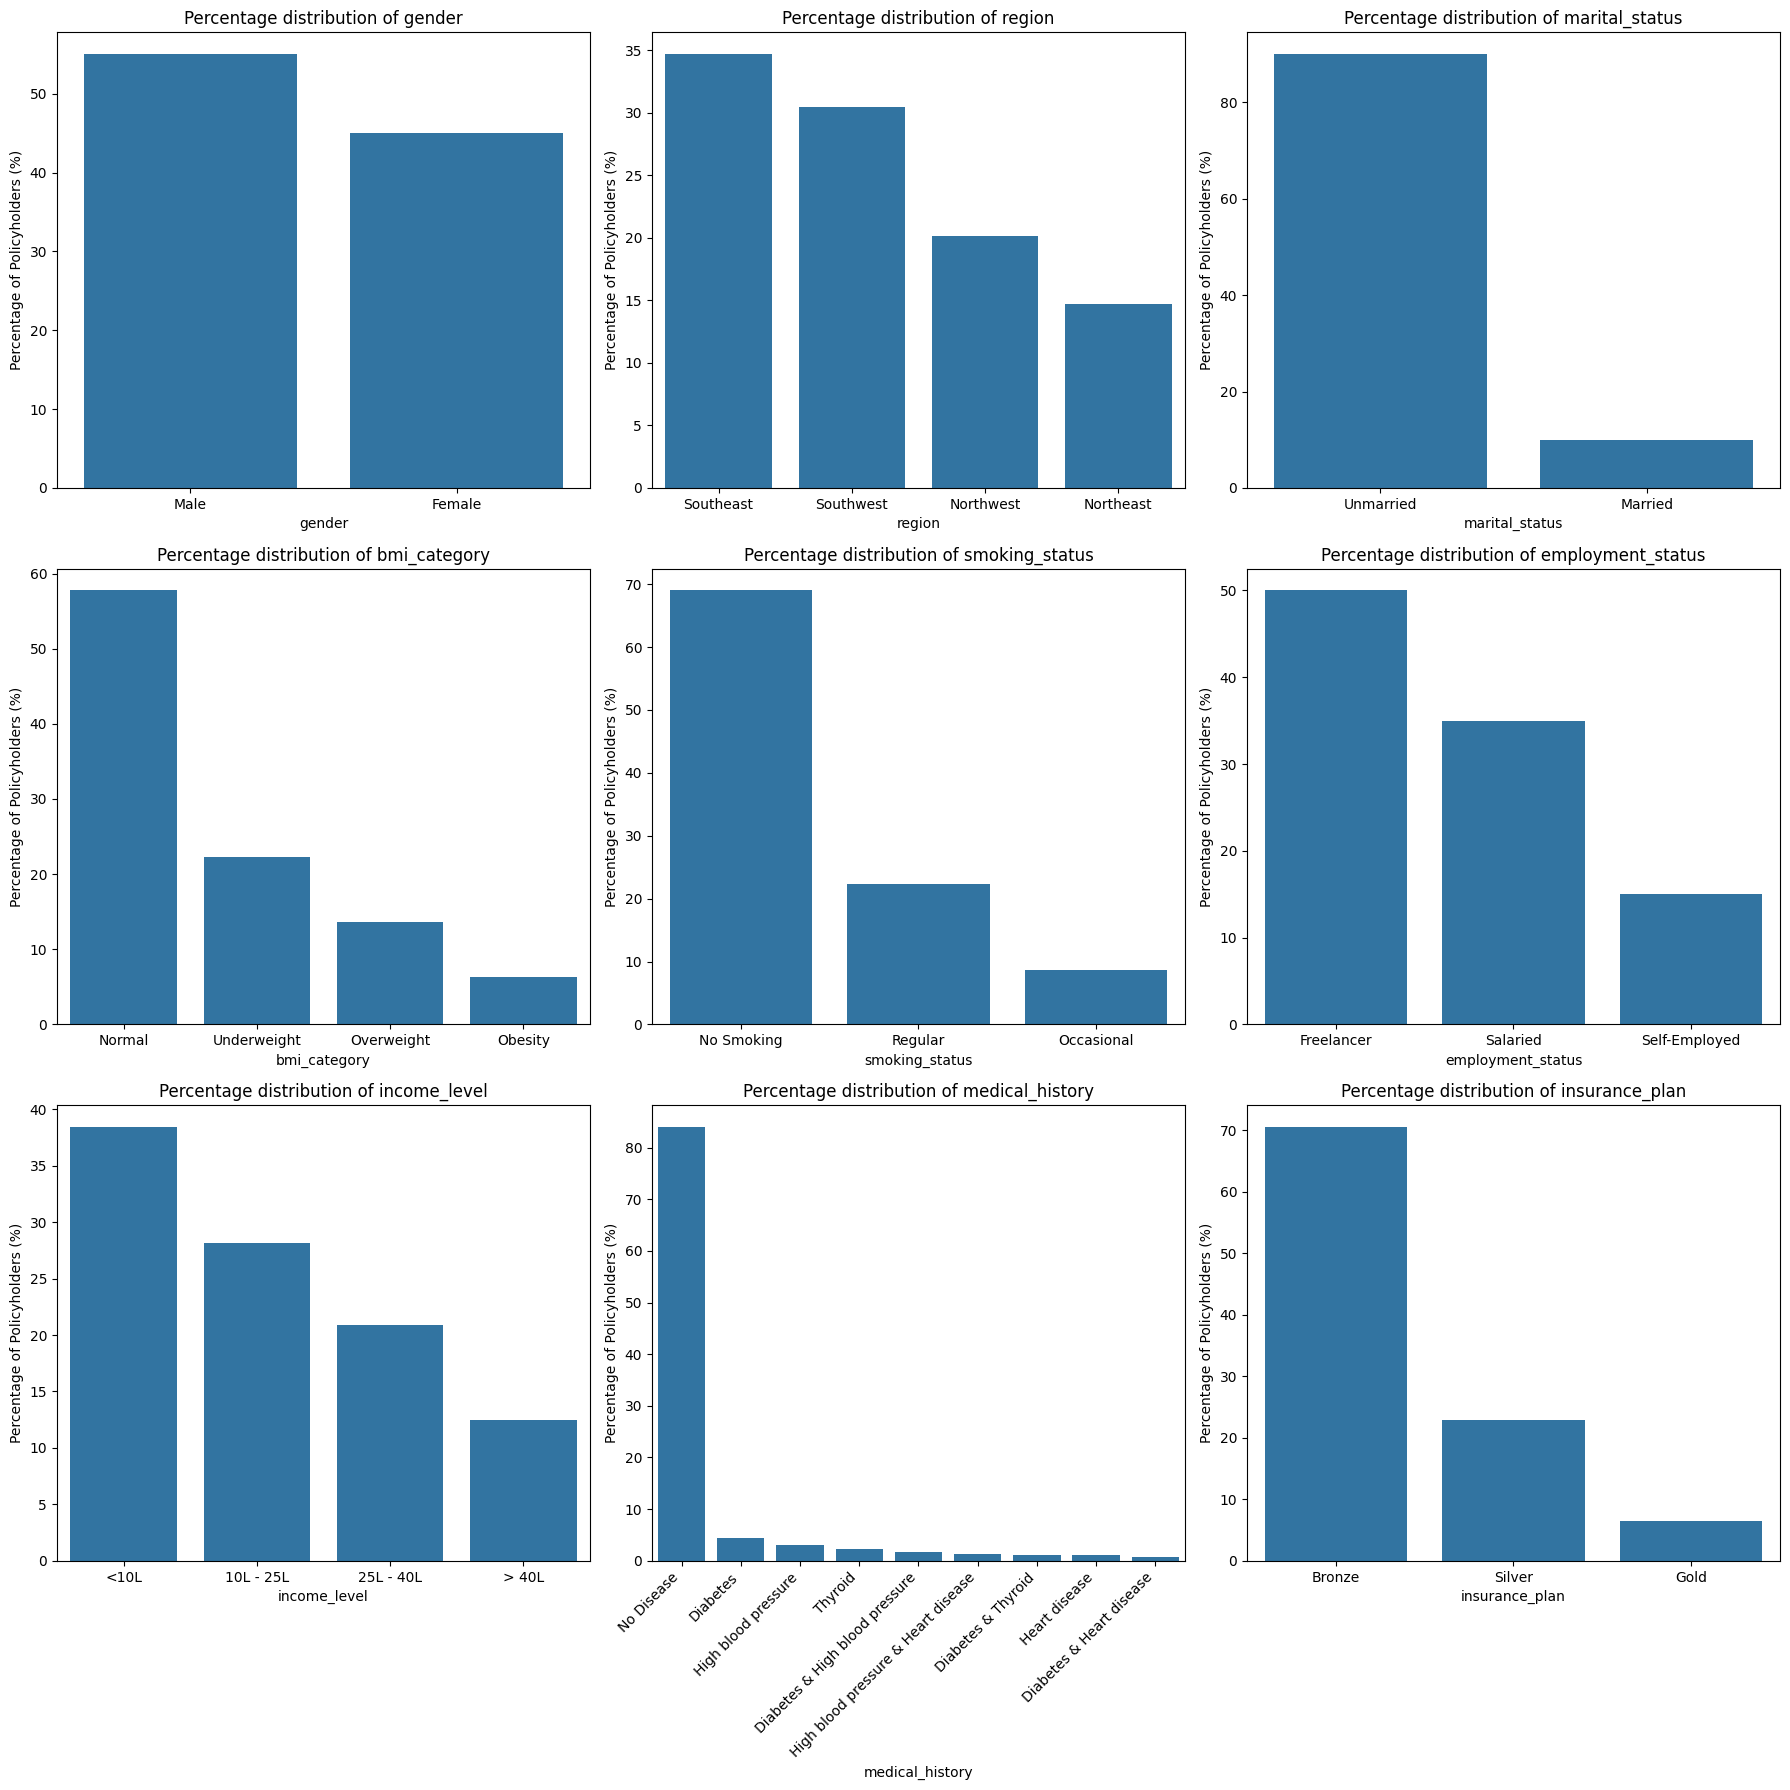

In [124]:
fig, axes = plt.subplots(3,3, figsize = (18,18))
axes = axes.flatten()

for ax,col in zip(axes,categorical_cols):
    category_counts = df2[col].value_counts(normalize=True) * 100

    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f"Percentage distribution of {col}")
    ax.set_ylabel("Percentage of Policyholders (%)")
    ax.set_xlabel(col)

    if col == 'medical_history':
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Bivariate analysis for categorical columns: Income Level and type of Insurance Plan

In [125]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


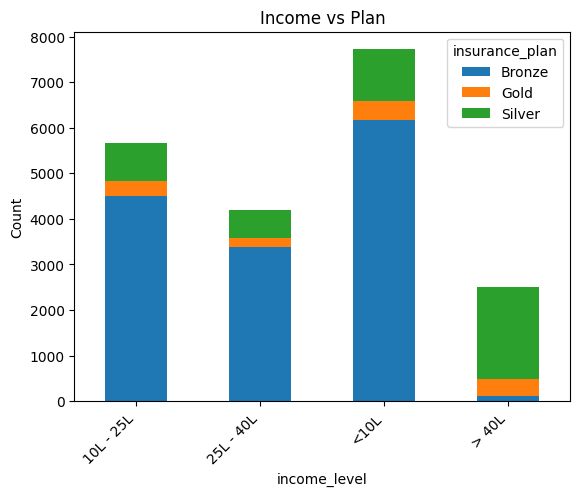

In [126]:
crosstab.plot(kind="bar", stacked = True)
plt.title("Income vs Plan")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

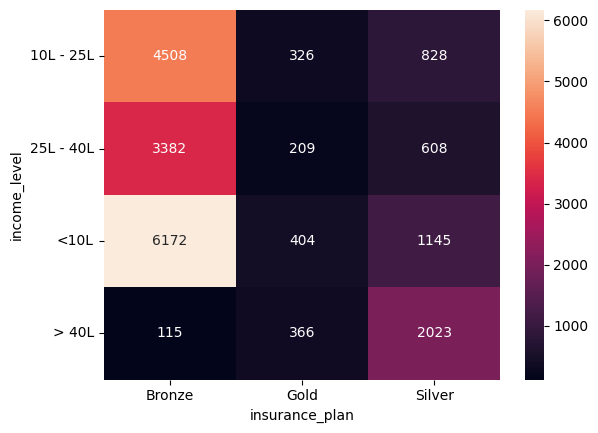

In [127]:
sns.heatmap(crosstab, annot=True, fmt='d')
plt.yticks(rotation=0)
plt.show()

### Feature Engineering

#### Ordinal variable columns

In [128]:
df2['medical_history'].unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [129]:
#Upon talking with the client, we have decided to assign certain risk scores for diseases. 
#If a person has multiple diseases, the total risk score would be the sum of individual risk scores.

risk_scores = {
    "diabetes" : 6,
    "high blood pressure" : 6,
    "thyroid" : 5,
    "heart disease" : 8,
    "no disease": 0,
    "none": 0
}

In [130]:
#Creating new columns for multiple diseases

df2[['disease_1','disease_2']] = df2['medical_history'].str.split("&", expand=True).apply(lambda x:x.str.lower().str.strip())
df2.head(10)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,None
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,None
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,None
5,22,Female,Southwest,Unmarried,0,Underweight,Regular,Freelancer,25L - 40L,30,High blood pressure,Gold,15473,high blood pressure,None
6,19,Male,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,<10L,8,No Disease,Bronze,4097,no disease,None
7,18,Female,Northwest,Unmarried,1,Underweight,No Smoking,Salaried,<10L,5,Diabetes & High blood pressure,Bronze,8187,diabetes,high blood pressure
8,23,Male,Northwest,Unmarried,0,Underweight,No Smoking,Salaried,<10L,8,No Disease,Bronze,5387,no disease,None
9,20,Female,Northeast,Unmarried,0,Normal,Occasional,Salaried,10L - 25L,18,No Disease,Bronze,8866,no disease,None


In [131]:
df2['disease_1'] = df2['disease_1'].fillna('none')
df2['disease_2'] = df2['disease_2'].fillna('none')
df2['total_risk_score'] = 0

for disease in ['disease_1','disease_2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score']-min_score)/(max_score-min_score)
df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2,total_risk_score,normalized_risk_score
19017,21,Male,Northeast,Unmarried,0,Normal,Regular,Freelancer,10L - 25L,11,No Disease,Bronze,7219,no disease,none,0,0.000000
8731,22,Male,Northeast,Unmarried,0,Normal,No Smoking,Salaried,> 40L,67,No Disease,Silver,9421,no disease,none,0,0.000000
7482,22,Male,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,14,High blood pressure,Bronze,4167,high blood pressure,none,6,0.428571
9179,25,Male,Southwest,Unmarried,1,Overweight,No Smoking,Self-Employed,> 40L,85,No Disease,Gold,12776,no disease,none,0,0.000000
6184,24,Female,Southeast,Unmarried,1,Overweight,Regular,Freelancer,> 40L,84,Thyroid,Silver,11734,thyroid,none,5,0.357143


In [132]:
df2['insurance_plan'].unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [133]:
insurance_plan_order = {
    'Bronze' : 1,
    'Silver' : 2,
    'Gold' : 3
}

df2['insurance_plan'] = df2['insurance_plan'].map(insurance_plan_order)
df2['insurance_plan'].unique()

array([2, 1, 3])

In [134]:
df2['income_level'].unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [135]:
income_level_order = {
    '<10L' : 1,
    "10L - 25L" : 2,
    "25L - 40L": 3,
    "> 40L" : 4
}

In [136]:
df2['income_level'] = df2['income_level'].map(income_level_order)
df2['income_level'].unique()

array([4, 1, 2, 3])

In [137]:
df2.head(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,15,No Disease,1,5684,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,2,14,No Disease,1,5712,no disease,none,0,0.000000


#### Nominal variable columns

In [138]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']

In [139]:
# One hot encoding
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease_1,disease_2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,No Disease,1,5684,no disease,none,0,...,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,No Disease,1,5712,no disease,none,0,...,1,0,1,0,1,0,0,0,0,0


In [140]:
# Dropping unnecessary columns
df4 = df3.drop(['medical_history', 'disease_1', 'disease_2', 'total_risk_score'], axis = 1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,5712,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


### Discovering the co-relation between variables

In [141]:
cm = df4.corr()
cm

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
age,1.000000,0.003096,-0.010634,-0.016671,-0.018195,-0.010815,0.003074,0.007791,0.002698,-0.003419,0.006922,0.000389,-0.001597,0.022006,-0.003068,-0.011040,-0.009827,-0.009493,0.001680
number_of_dependants,0.003096,1.000000,-0.014268,-0.014835,0.007802,0.005909,0.044009,-0.008213,0.014965,-0.000088,-0.011166,-0.722696,0.004090,0.002822,-0.000630,-0.015309,-0.001891,-0.013320,0.010281
income_level,-0.010634,-0.014268,1.000000,0.908131,0.322278,0.244373,-0.005214,0.026991,-0.003467,-0.003369,0.011454,0.012376,0.011474,0.013096,-0.003746,0.006059,0.000315,-0.111361,0.103160
income_lakhs,-0.016671,-0.014835,0.908131,1.000000,0.380968,0.290683,-0.006630,0.000951,-0.006349,-0.004859,0.015674,0.014021,0.014379,0.008312,-0.000598,0.006187,-0.010641,-0.084416,0.083316
insurance_plan,-0.018195,0.007802,0.322278,0.380968,1.000000,0.761004,0.001951,-0.016589,-0.006221,-0.007836,0.013644,-0.006561,0.002285,-0.006236,0.007766,-0.001517,-0.008755,-0.016911,0.026543
annual_premium_amount,-0.010815,0.005909,0.244373,0.290683,0.761004,1.000000,0.090702,0.000251,-0.017573,0.002388,0.008090,-0.008706,0.064828,0.036573,0.004972,0.008673,0.085407,-0.015318,0.024136
normalized_risk_score,0.003074,0.044009,-0.005214,-0.006630,0.001951,0.090702,1.000000,-0.000234,-0.000102,-0.008037,-0.004214,-0.056335,0.001278,0.000108,-0.010735,-0.008724,0.003557,-0.005101,-0.002150
gender_Male,0.007791,-0.008213,0.026991,0.000951,-0.016589,0.000251,-0.000234,1.000000,-0.002796,-0.000131,-0.002445,0.009276,-0.061257,0.043389,-0.060075,0.053469,0.202788,0.006978,-0.001052
region_Northwest,0.002698,0.014965,-0.003467,-0.006349,-0.006221,-0.017573,-0.000102,-0.002796,1.000000,-0.365912,-0.332236,-0.009604,-0.010099,0.003283,0.003720,-0.000543,-0.002375,0.010613,0.000254
region_Southeast,-0.003419,-0.000088,-0.003369,-0.004859,-0.007836,0.002388,-0.008037,-0.000131,-0.365912,1.000000,-0.482398,0.000952,0.004409,0.010248,0.001118,-0.006319,-0.001805,-0.004268,0.000575


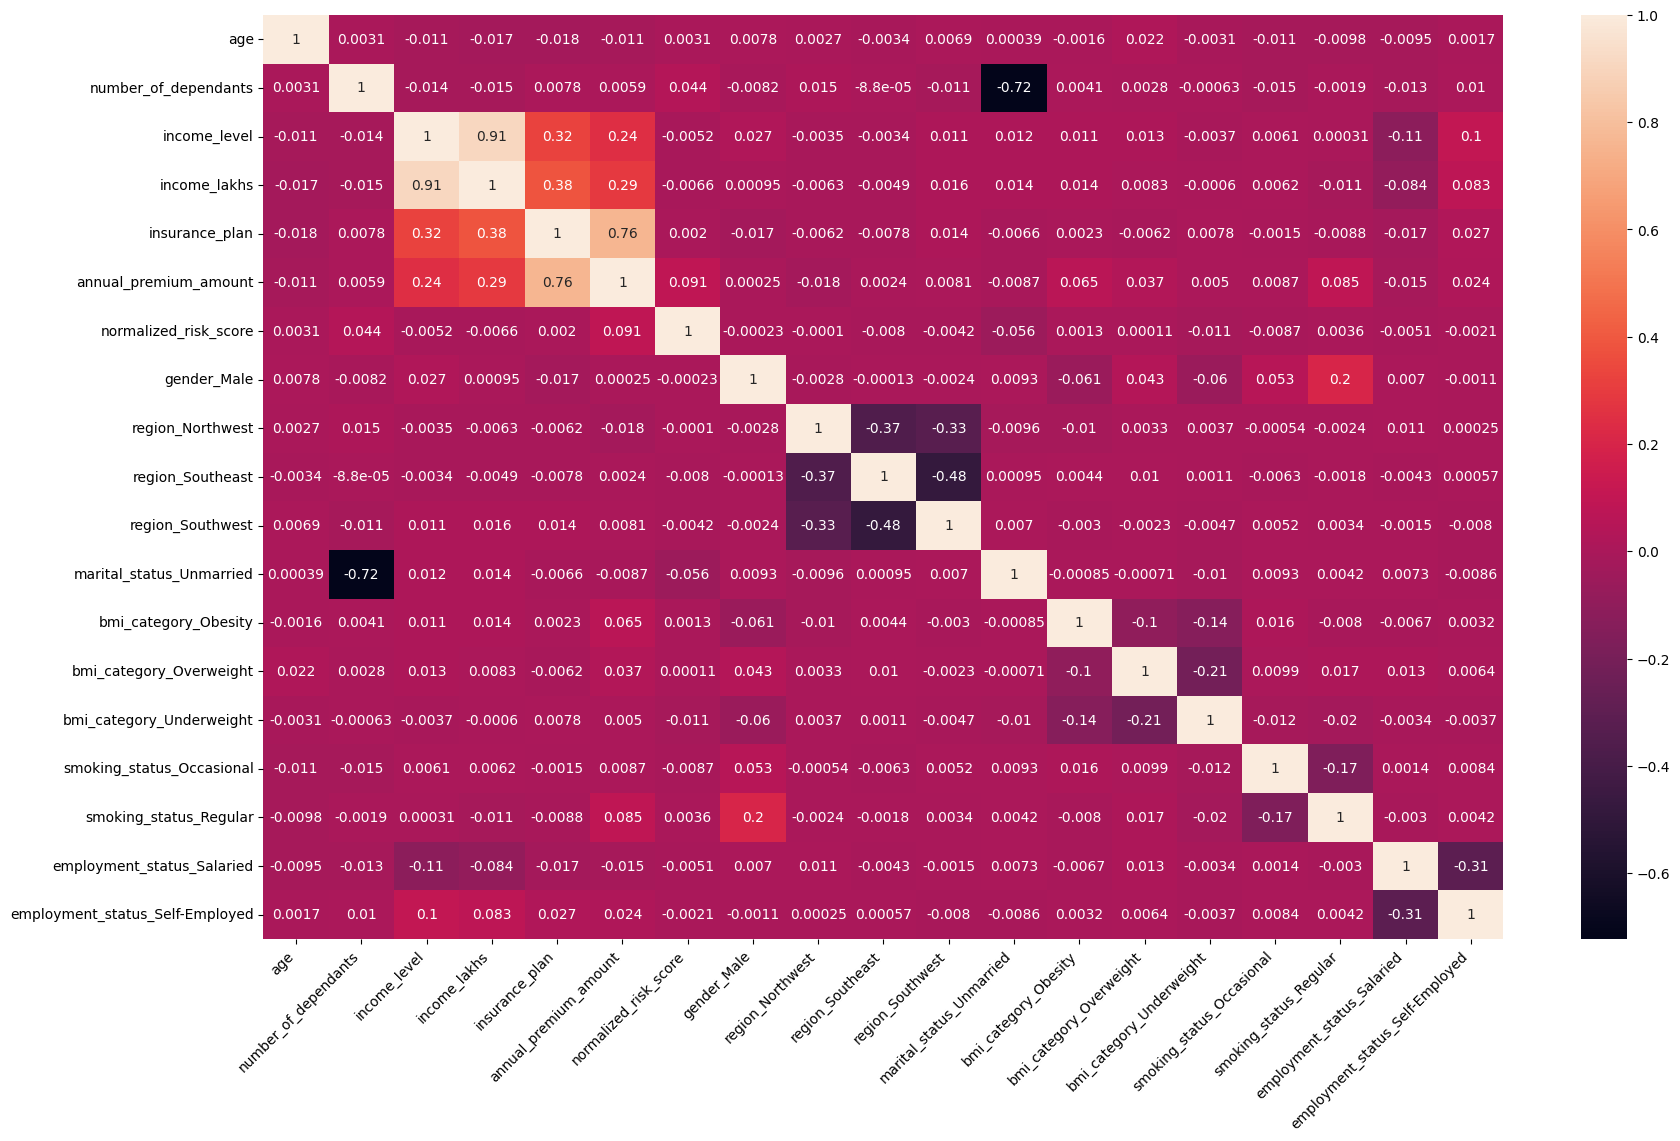

In [142]:
plt.figure(figsize = (20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout
plt.show()

### Separating independent and target variables

In [143]:
X = df4.drop('annual_premium_amount', axis=1)
y = df4['annual_premium_amount']

In [144]:
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


### Scaling all the values to be between 0 and 1

In [145]:
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']

In [146]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,1.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.333333,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.333333,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


In [147]:
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Calculating VIF for independent variables

In [148]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [149]:
calculate_vif(X)

,column,VIF
0,age,3.142881
1,number_of_dependants,1.860761
2,income_level,11.928707
3,income_lakhs,11.874242
4,insurance_plan,1.592892
5,normalized_risk_score,1.154223
6,gender_Male,2.310023
7,region_Northwest,2.147701
8,region_Southeast,2.970188
9,region_Southwest,2.730503


In [150]:
X_reduced = X.drop('income_level', axis = 1)
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


In [151]:
calculate_vif(X_reduced)

,column,VIF
0,age,3.141534
1,number_of_dependants,1.858110
2,income_lakhs,2.291873
3,insurance_plan,1.587794
4,normalized_risk_score,1.154174
5,gender_Male,2.299848
6,region_Northwest,2.146767
7,region_Southeast,2.968993
8,region_Southwest,2.729813
9,marital_status_Unmarried,7.299818


### Model Training

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print('y_test:', y_test.shape)

X_train: (14060, 17)
X_test: (6026, 17)
y_train: (14060,)
y_test: (6026,)


In [153]:
model_lr = LinearRegression()

In [154]:
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)

print(f"Train Score: {train_score}, Test Score: {test_score}")

Train Score: 0.6020471274164894, Test Score: 0.6047589163893645


In [155]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)

print("Linear Regression ==> MSE:", mse_lr, "RMSE:", rmse_lr)

Linear Regression ==> MSE: 3005669.8791236714 RMSE: 1733.6867880686152


### Checking how the weights of each column contribute to the final annual premium amount

In [156]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12774,1.0,0.666667,0.040404,0.0,0.0,1,0,0,1,1,0,0,1,0,0,0,0


In [157]:
model_lr.intercept_

np.float64(6614.583391230751)

In [158]:
model_lr.coef_

array([ 5.51905147e+01, -1.45039643e+02, -3.60667677e+01,  7.00007042e+03,
        1.11127879e+03,  9.82564766e+00, -1.14273450e+02, -3.64663714e+01,
       -6.72232248e+01, -5.85343424e+01,  7.92952660e+02,  4.35760406e+02,
        1.69728916e+02,  2.44813937e+02,  6.19082947e+02, -1.30535485e+01,
       -4.34272200e+00])

In [159]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index = X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

,Coefficients
number_of_dependants,-145.039643
region_Northwest,-114.273450
region_Southwest,-67.223225
marital_status_Unmarried,-58.534342
region_Southeast,-36.466371
income_lakhs,-36.066768
employment_status_Salaried,-13.053549
employment_status_Self-Employed,-4.342722
gender_Male,9.825648
age,55.190515


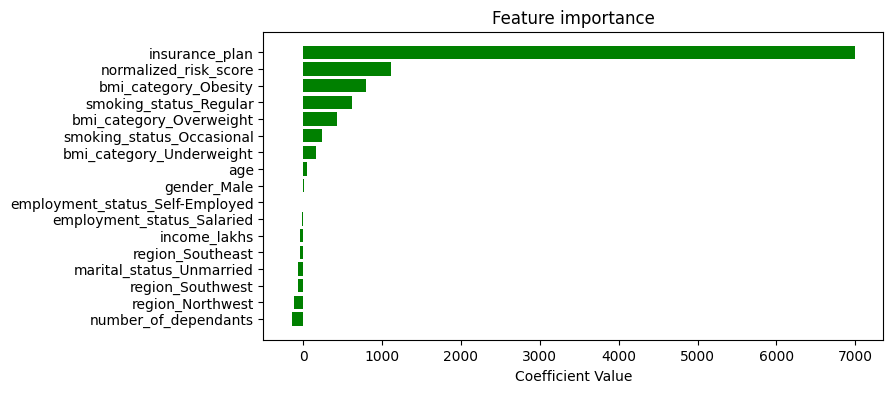

In [160]:
plt.figure(figsize=(8,4))
plt.barh(coef_df.index,coef_df['Coefficients'], color= 'green')
plt.title('Feature importance')
plt.xlabel('Coefficient Value')
plt.show()

### Attempts to improve the model accuracy

In [161]:
model_rg = Ridge(alpha=10)
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)

print(f"Train Score: {train_score}, Test Score: {test_score}")

Train Score: 0.6020016973203524, Test Score: 0.6048405530676814


In [162]:
from xgboost import XGBRegressor

In [163]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)

print(f"Train Score: ({train_score}), Test Score: ({test_score})")

Train Score: (0.7251046895980835), Test Score: (0.5638787746429443)


In [164]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression ==> MSE:", mse_xgb, "RMSE:", rmse_xgb)

XGBoost Regression ==> MSE: 3316549.0 RMSE: 1821.1394784584731


In [165]:
param_grid = {
    'n_estimators' : [20, 40, 50],
    'learning_rate' : [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter = 10, cv = 3, scoring = 'r2', random_state=4)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.5997088948885599)

In [166]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [167]:
random_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

In [168]:
best_model = model_lr

### Error Analysis

In [169]:
y_pred = best_model.predict(X_test)

residuals = y_pred-y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct':residuals_pct
})

results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6625.420564,387.420564,6.210653
14758,9462,7117.148903,-2344.851097,-24.781770
13205,5152,7052.316369,1900.316369,36.885023
14278,6988,7924.504344,936.504344,13.401608
19351,4917,6696.274716,1779.274716,36.186185


<Axes: xlabel='diff_pct', ylabel='Count'>

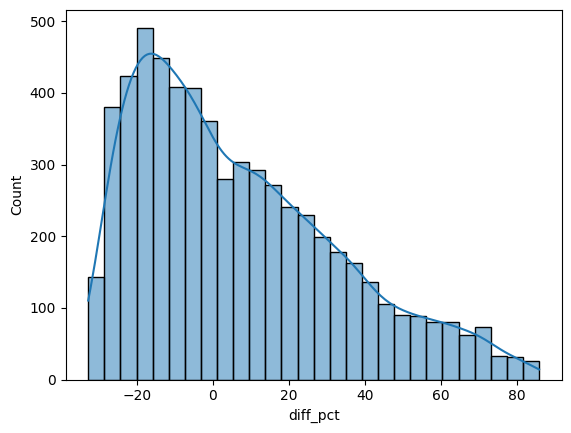

In [170]:
sns.histplot(results_df['diff_pct'], kde=True)

In [171]:
extreme_error_thresold = 10
extreme_results_df = results_df[np.abs((results_df.diff_pct))>extreme_error_thresold]
extreme_results_df.shape

(4404, 4)

In [172]:
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

73.08330567540658

In [173]:
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct', ascending = False)

,actual,predicted,diff,diff_pct
10288,3623,6730.355627,3107.355627,85.767475
16580,3538,6566.644257,3028.644257,85.603286
3652,3536,6560.929382,3024.929382,85.546645
17084,3562,6608.314334,3046.314334,85.522581
18629,3616,6684.432249,3068.432249,84.857087
...,...,...,...,...
1597,4653,6988.954171,2335.954171,50.203184
12185,4440,6666.968404,2226.968404,50.156946
15966,4709,7070.742860,2361.742860,50.153809
4086,4592,6890.471576,2298.471576,50.053824


In [174]:
#The index in extreme_results_df is same as the index in X_test. So figuring out the features of these high error predictions

extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14758,0.285714,0.000000,0.060606,0.0,0.000000,0,0,0,1,1,0,0,0,0,1,0,1
13205,0.714286,0.333333,0.141414,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,1
14278,0.714286,0.333333,0.222222,0.0,0.000000,1,0,1,0,1,1,0,0,0,1,0,0
19351,0.571429,0.000000,0.101010,0.0,0.000000,1,0,0,1,1,0,0,1,0,0,0,0
10622,0.428571,0.333333,0.050505,0.0,0.357143,0,0,1,0,1,0,1,0,0,0,0,0


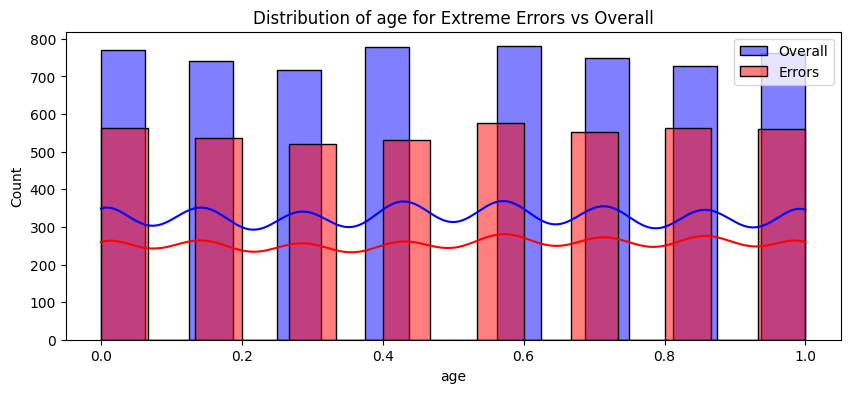

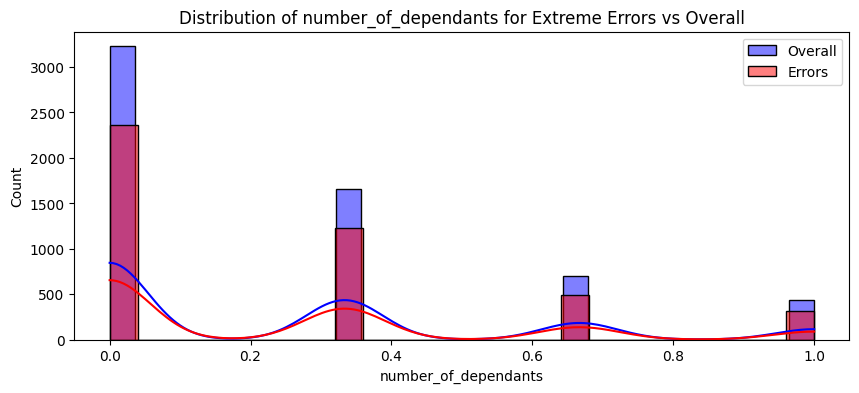

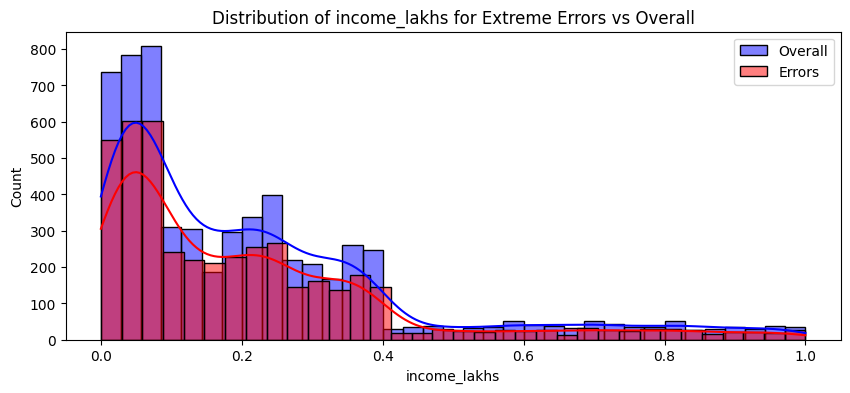

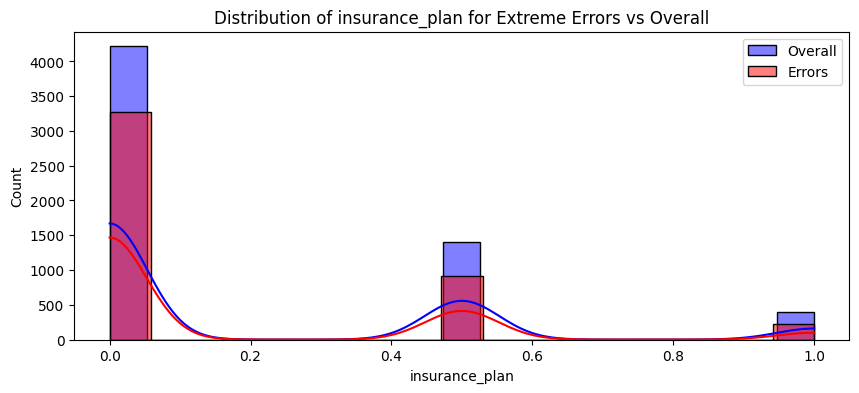

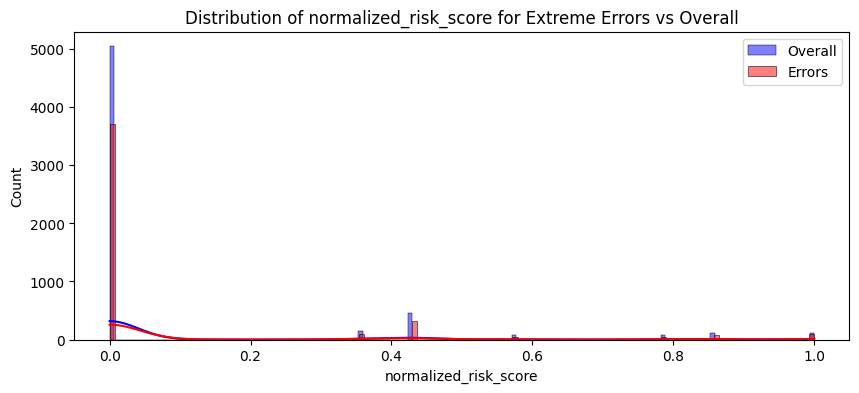

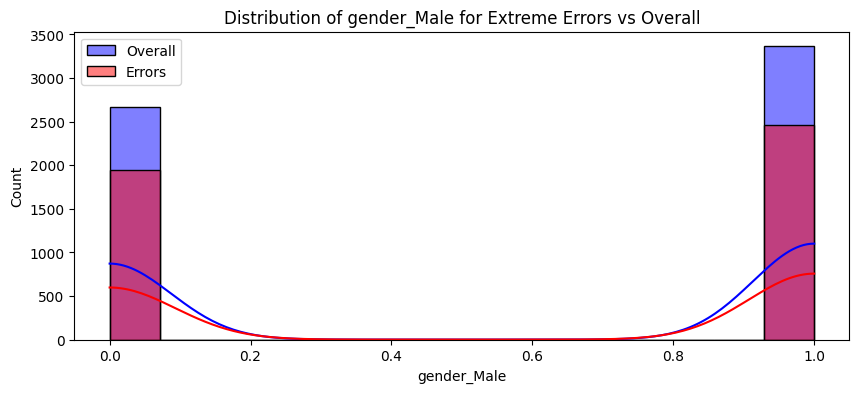

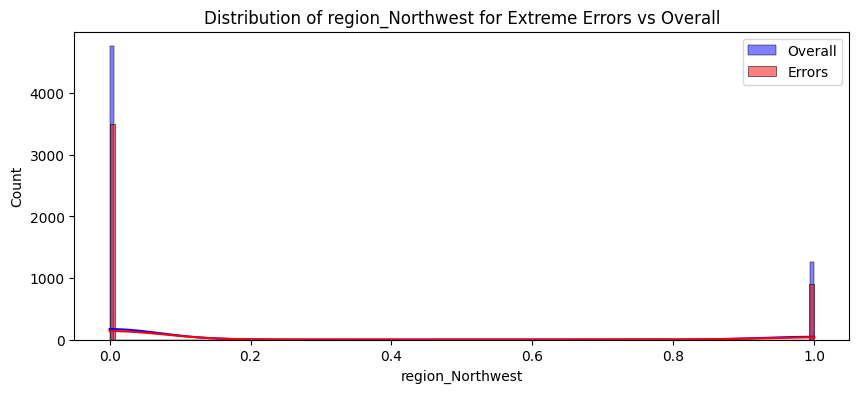

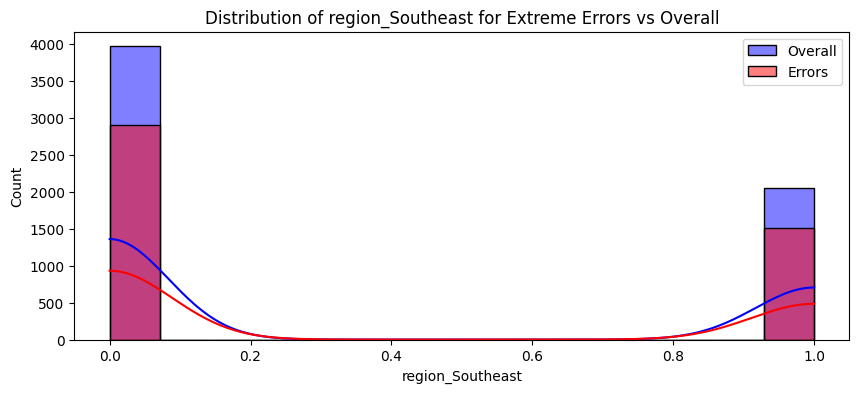

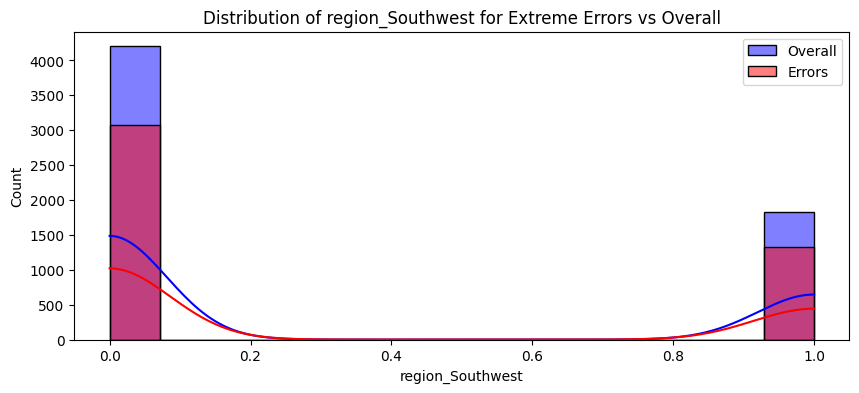

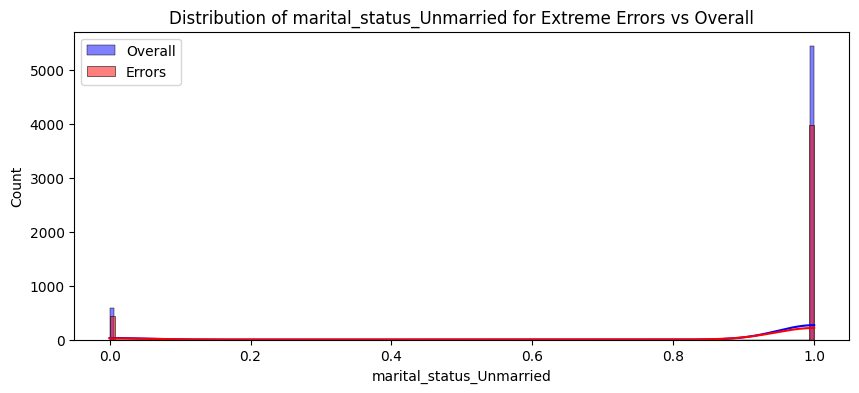

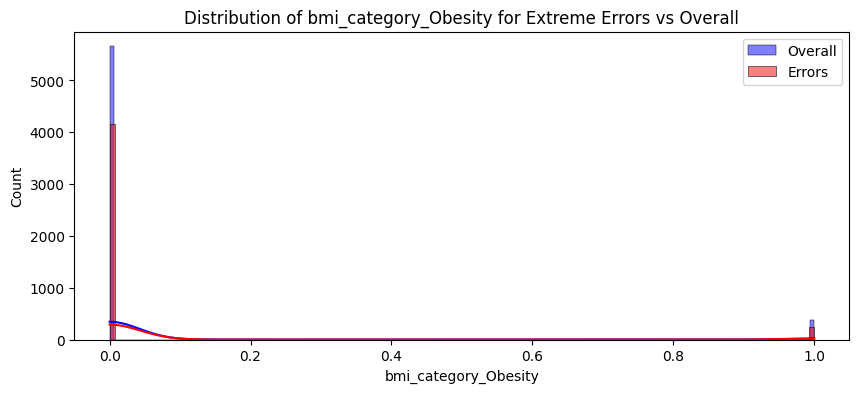

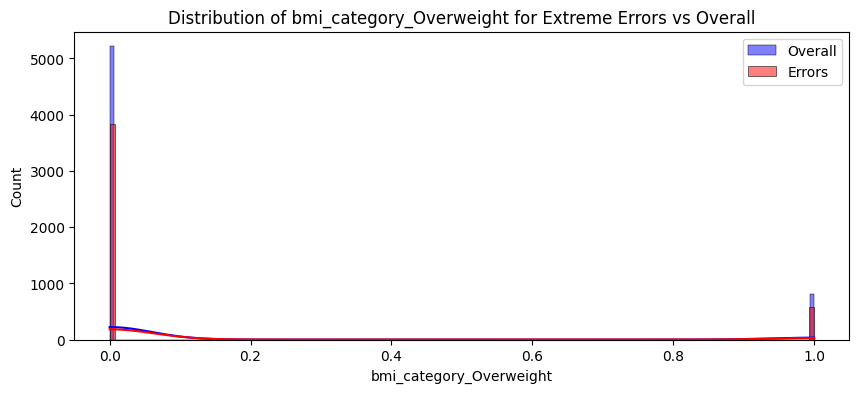

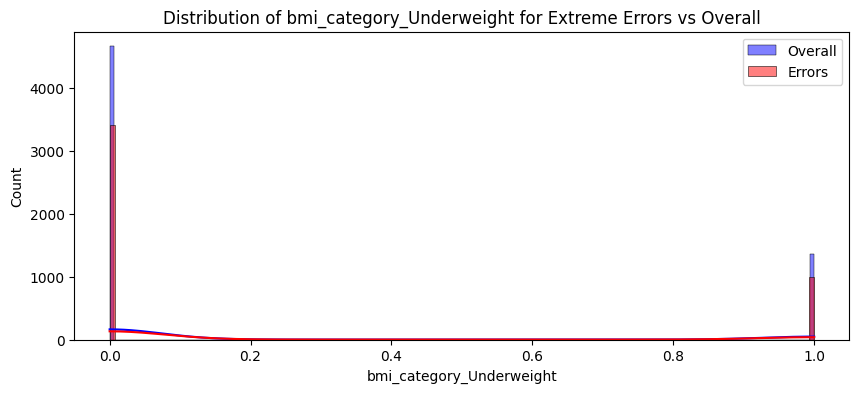

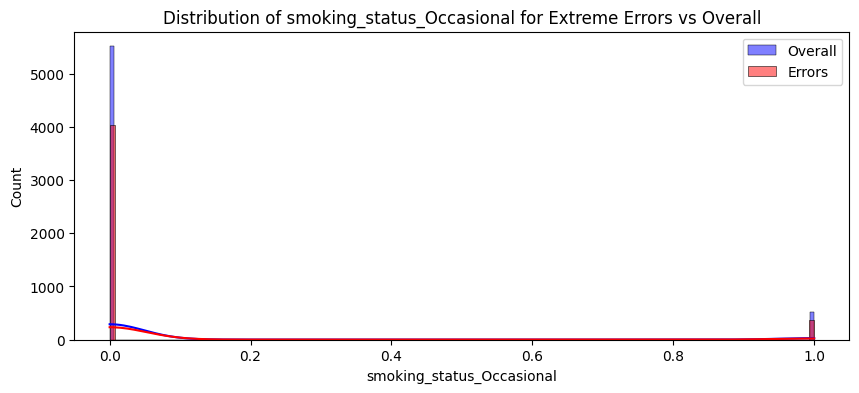

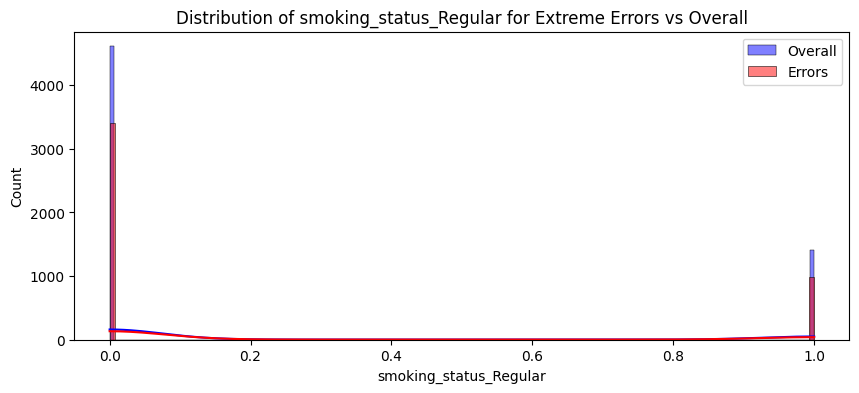

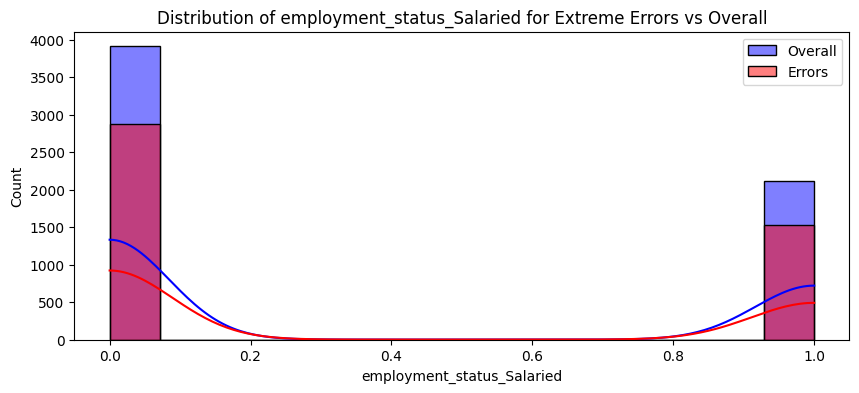

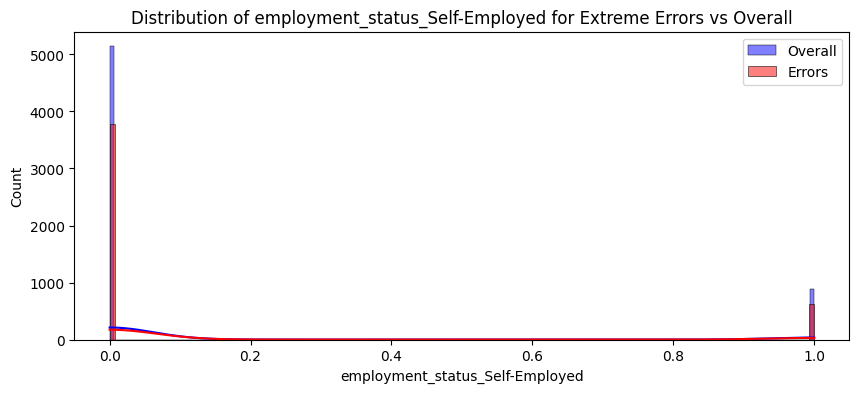

In [175]:
for feature in X_test.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    sns.histplot(extreme_errors_df[feature], color='red', label='Errors', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

<Axes: xlabel='age', ylabel='Count'>

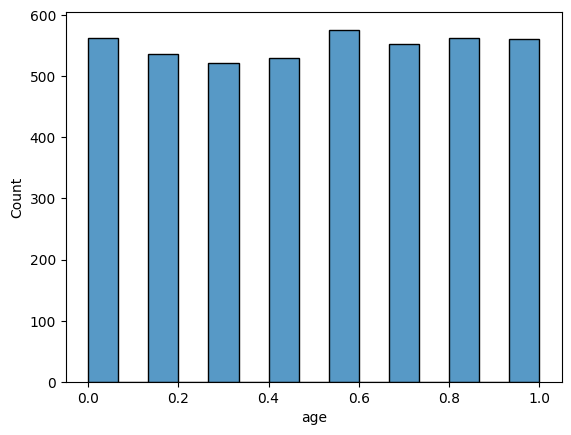

In [176]:
sns.histplot(extreme_errors_df.age)

### Reversing the scaling done previously

In [177]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [178]:
extreme_errors_df['income_level'] = -1

In [179]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed[cols_to_scale].head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,20.0,0.0,-2.0,7.0,1.0
1,23.0,1.0,-2.0,15.0,1.0
2,23.0,1.0,-2.0,23.0,1.0
3,22.0,0.0,-2.0,11.0,1.0
4,21.0,1.0,-2.0,6.0,1.0


<Axes: xlabel='age', ylabel='Count'>

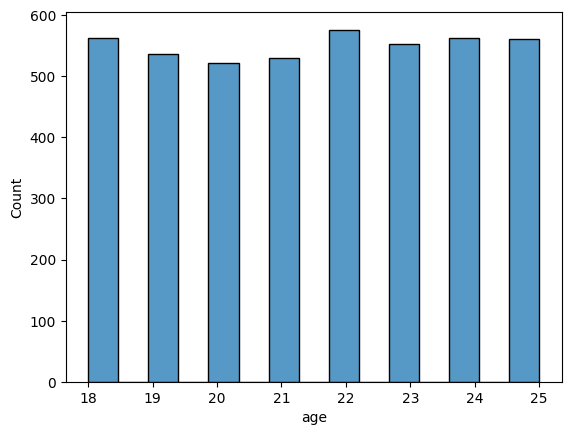

In [180]:
sns.histplot(df_reversed['age'])

In [181]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4404.000000,4404.000000,4404.0,4404.000000,4404.000000
mean,21.529292,0.719346,-2.0,21.506585,1.307902
std,2.302041,0.926202,0.0,20.970951,0.559534
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,20.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,30.000000,2.000000
max,25.000000,3.000000,-2.0,100.000000,3.000000


In [182]:
df_reversed['age'].quantile(0.98)

np.float64(25.0)